In [20]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib import transforms
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import matplotlib.text as mtext

from matplotlib.patches import Rectangle
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
from shapely.geometry import Polygon
from scipy import ndimage

%matplotlib notebook

def multi2single(gpdf):
    gpdf_singlepoly = gpdf[gpdf.geometry.type == 'Polygon']
    gpdf_multipoly = gpdf[gpdf.geometry.type == 'MultiPolygon']

    for i, row in gpdf_multipoly.iterrows():
        Series_geometries = pd.Series(row.geometry)
        df = pd.concat([gpd.GeoDataFrame(row, crs=gpdf_multipoly.crs).T]*len(Series_geometries), ignore_index=True)
        df['geometry']  = Series_geometries
        gpdf_singlepoly = pd.concat([gpdf_singlepoly, df])

    gpdf_singlepoly.reset_index(inplace=True, drop=True)
    return gpdf_singlepoly

def Scale_Arrow(Units,offset):
    bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="white", ec="black", lw=1)
    t = ax1.text(xl[1]-offset*2,yl[0]+offset*2, "   ", ha="center", va="center", rotation=90+rotation,
                size=10,
                bbox=bbox_props)
    t = ax1.text(xl[1]-offset*2,yl[0]+offset*2, "N", ha="center", va="center", rotation=rotation,
                size=10)


    ax1.add_patch(Rectangle((xl[0]+offset,yl[0]+offset),Units,25,
                       edgecolor='black',facecolor='white',lw=1))
    ax1.text(xl[0]+Units+offset*1.6,yl[0]+offset*1.3,
        str(Units)+' m',fontsize=10,rotation=0)
    
class LegendTitle(object):
    def __init__(self, text_props=None):
        self.text_props = text_props or {}
        super(LegendTitle, self).__init__()

    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, Y_1 = handlebox.xdescent, handlebox.ydescent
        title = mtext.Text(x0, Y_1,  orig_handle, **self.text_props)
        handlebox.add_artist(title)

## Map Paramters

In [21]:
Size = (6.5,7)
Scale = 440
Center = [516250,7708050]
X_0,Y_0,X_0s,Y_0s = 0.02,0.02,0.98,0.98
X_1,Y_1,X_1s,Y_1s = 0.025, 0.425, 0.97, 0.5
X_2,Y_2,X_2s,Y_2s = 0.48, 0.025, 0.515, 0.375
X_3,Y_3,X_3s,Y_3s = 0.025, 0.025, 0.44, 0.355


xScale = Scale
yScale = Scale * Y_1s/X_1s * Size[1]/Size[0]
# print(yScale/xScale*X_2s)
# Y_2s = yScale/xScale*X_2s
xl = Center[0]-xScale,Center[0]+xScale
yl = Center[1]-yScale,Center[1]+yScale

Colors = {
'Shrub':[.6,1,0.3],
'Sedge':[0.1,1,0.75],
'Fen':[0.1,1,0.75],
'Grass':[1,.7,.3],
'Sparse':[.85,.85,.85],
'Upland':[.95,.9,.8],
'Water':[0.5,0.5,1],
'Ocean':[0.5,0.5,1]
}

rotation = -22
polygon = Polygon([[xl[0], yl[0]], [xl[1], yl[0]], [xl[1], yl[1]], [xl[0], yl[1]]])
Box = gpd.GeoDataFrame(index=[0],data={'geometry':polygon})
Box.geometry = Box.geometry.rotate(-rotation,origin = Center)

Veg = 'C:/Illisarvik/Mapping/Vegetation_Skeeter_3.3.shp'
Clim = 'C:/Illisarvik/Footprints/Contours/Climatology.shp'
Chambers = "C:/Illisarvik/Mapping/Basin_Points.shp"
img = mpimg.imread("C://Illisarvik//Photos//DronePhotos//Oblique//DJI_0123.JPG")
Y_2s = (img.shape[0]/img.shape[1]*X_2s)*Size[0]/Size[1]
Y_3s = Y_2s + 0

Clim = gpd.read_file(Clim)
Veg = gpd.read_file(Veg)
Chambers = gpd.read_file(Chambers)
Veg.loc[Veg['Id']=='0','DKey']='1'
Basin = Veg.dissolve(by='DKey').buffer(.01) ## Buffer to get rid of overlap slivers
Basin = gpd.GeoDataFrame(data={'geometry':Basin.geometry})

Veg = Veg.sort_values('Unit')
Veg.reset_index(inplace=True)
Veg = gpd.overlay(Veg, Box, how='intersection')
Veg = Veg.dissolve(by='index')
Veg = multi2single(Veg)

Veg['coords'] = Veg['geometry'].apply(lambda x: x.representative_point().coords[:])
Veg['coords'] = [coords[0] for coords in Veg['coords']]

Labels = gpd.GeoDataFrame(Veg['geometry'].apply(lambda x: x.representative_point()))
Labels['Unit'] = Veg['Unit']

Veg.geometry = Veg.geometry.rotate(rotation,origin = Center)
Chambers.geometry = Chambers.geometry.rotate(rotation,origin = Center)
Basin.geometry = Basin.geometry.rotate(rotation,origin = Center)
Clim.geometry = Clim.geometry.rotate(rotation,origin = Center)
Labels.geometry = Labels.geometry.rotate(rotation,origin = Center)
Labels['coords'] = Labels['geometry'].apply(lambda x: x.coords[:])
Labels['coords'] = [coords[0] for coords in Labels['coords']]


Basin.to_file('C:/Illisarvik/Mapping/Illisarvik.shp')

C:\Anaconda3\lib\site-packages\geopandas\base.py:29: UserWarning: GeoSeries crs mismatch: {'init': 'epsg:26908'} and None
  other.crs))


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.path as mpath
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.collections import PatchCollection


def label(ax3,xy, text,xoff=.1):
    x = xy[0] + xoff  # shift x-value for label so that it's below the artist
    ax3.text(x, xy[1], text, ha='left', family='sans-serif', size=12)

def box(xy,l,w,h=0):
    xyn = [xy[0],xy[1]+h]
    return(mpatches.Rectangle(xyn,l,w))

def ball(xy,r,h=0):
    xyn = [xy[0]+r,xy[1]+r+h]
    return(mpatches.Circle(xyn,r))

def line(xy,l,w=.1,h=0,lbl='Line',color = 'b',style = '-'):
#     print(style)
    return(mlines.Line2D([xy[0],xy[0]+l],[xy[1]+h,xy[1]+h], color=color, 
                         linestyle=style,linewidth = w, label=lbl))

# create 1x8 grid to plot the artists

import matplotlib.patheffects as pe

<IPython.core.display.Javascript object>


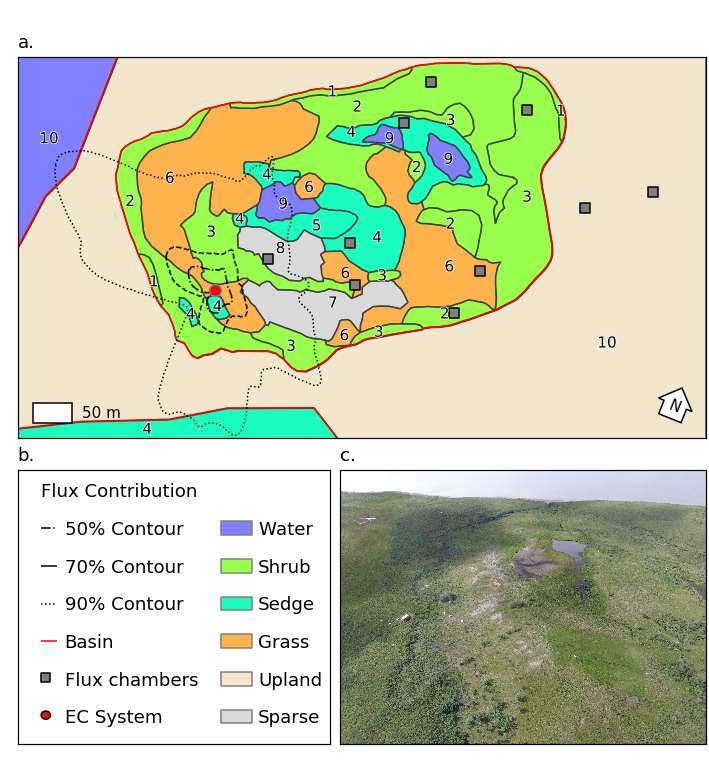

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


In [17]:
fig = plt.figure(figsize = Size)
ax = fig.add_axes([X_0,Y_0,X_0s,Y_0s])
ax1 = fig.add_axes([X_1,Y_1,X_1s,Y_1s])
# X_2s = img.shape[1]/img.shape[0]*Y_2s
# print([X_2,Y_2,X_2s,Y_2s])
# print([X_3,Y_3,X_3s,Y_3s])
ax2 = fig.add_axes([X_2,Y_2,X_2s,Y_2s])

ax3 = fig.add_axes([X_3,Y_3,X_3s,Y_3s])

ax1.set_xlim(xl)
ax1.set_ylim(yl)

ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax.axis('off')
# ax.axis('off')

Patches = []
Text = []

Classes = 'Vegetation\nClasses'
Flux = 'Flux Contribution'#\nContours'
Patches.append('')
Text.append('')
Patches.append(Classes)
Text.append('')
for cl in Veg['Class'].unique():
    Veg.loc[Veg['Class'] == cl].plot(
                        facecolor = Colors[cl],
                        edgecolor = [.25,.25,.25],
                        ax = ax1,
                        label=cl,             
    )
    if cl != "Fen" and cl != "Ocean": 
        Patches.append(mpatches.Patch(facecolor=Colors[cl],edgecolor=[.5,.5,.5], label=cl))
        Text.append(cl)

for idx, row in Labels.iterrows():
    ax1.annotate(s=row['Unit'], xy=row['coords'],fontsize=10,
                 horizontalalignment='center',verticalalignment='center',color='black',
                path_effects=[pe.withStroke(linewidth=1, foreground="white")])

Basin.plot(facecolor = 'None',edgecolor = 'red',ax = ax1,label='Basin')
L1 = mlines.Line2D([], [], color='red', label='Basin')

X = Chambers.loc[Chambers['Type']=='Chamber'].geometry.x
Y = Chambers.loc[Chambers['Type']=='Chamber'].geometry.y
ax1.scatter(X,Y,marker='s',facecolor = [0.5,0.5,0.5],edgecolor=[0,0,0],label='Chambers',s=50)

prms = {'facecolor':'None','edgecolor':'black'}
Clim.loc[Clim['contour'] == 0.5].plot(linestyle = '-.',
                                      ax=ax1,
                                      label='% Contour',
                                     **prms)
Clim.loc[Clim['contour'] == 0.7].plot(linestyle = '--',
                                      ax=ax1,
                                      label='% Contour',
                                     **prms)
Clim.loc[Clim['contour'] == 0.9].plot(linestyle = ':',
                                      ax=ax1,
                                     label='% Contour',
                                     **prms)

X = Chambers.loc[Chambers['Type']=='EC System'].geometry.x
Y = Chambers.loc[Chambers['Type']=='EC System'].geometry.y
ax1.scatter(X,Y,marker='o',facecolor = 'red',edgecolor='grey',label='Tripod',s=60)
ax2.imshow(img)

grid1 = np.mgrid[0.075:0.8:1, 0.075:0.9:7j].reshape(2, -1).T
grid2 = np.mgrid[0.65:0.8:1, 0.075:0.9:7j].reshape(2, -1).T
# print(grid,grid1)
# create patches
patches = []
edgecolors = []# ['b','y']#,'b','b','g','y']
facecolors = []# ['b','y']#,'b','b','r','g']
linestyles = []

i=0
for cl in Veg['Class'].unique():
    if cl != "Fen" and cl != "Ocean": 
        rect = box(grid2[i],.1,.05)
        label(ax3,grid2[i], cl,xoff = .12)
        facecolors.append(Colors[cl])
        edgecolors.append([.5,.5,.5])
        linestyles.append('-')
        patches.append(rect)  
        i+=1

i = 1
label(ax3,grid1[-1], Flux,xoff = 0)
for style,lbl,color in zip(['-.','-',':'],
                           ['50% Contour','70% Contour','90% Contour'],
                           ['black','black','black']):
    l = line(grid1[-i-1],.05,lbl=lbl,color = color,style = style,h=.025)
    patches.append(l)
    label(ax3,grid1[-i-1], lbl,xoff = .075)
    i += 1
    linestyles.append(style)
    facecolors.append([0,0,0])
    edgecolors.append([0,0,0])
    
l = line(grid1[-i-1],.05,lbl='Basin',color = [1,0,0],style = '-',h=.025)
patches.append(l)
label(ax3,grid1[-i-1], 'Basin',xoff = .075)
i += 1
linestyles.append('-')
facecolors.append([1,0,0])
edgecolors.append([1,0,0])


rect = box(grid1[-i-1],.03,.03,h=.015)
patches.append(rect)
label(ax3,grid1[-i-1], 'Flux chambers',xoff = .075)
facecolors.append([0.5,0.5,0.5])
edgecolors.append([0,0,0])
linestyles.append('-')
i+=1

circ = ball(grid1[-i-1],.015,h=.015)
patches.append(circ)
label(ax3,grid1[-i-1], 'EC System',xoff = .075)
facecolors.append([1,0,0])
edgecolors.append([0,0,0])
linestyles.append('-')
collection = PatchCollection(patches,edgecolors=edgecolors,
                             facecolors=facecolors,linestyles=linestyles)

ax3.add_collection(collection)

ax3.plot()
# plt.axis('equal')
ax3.set_xlim(0,1)
ax3.set_ylim(0,1)
# plt.axis('off')
plt.tight_layout()

Scale_Arrow(50,20)

ax1.set_title('a.',loc='left')# Illisarvik Vegetation, Flux Footprint, & Chamber Locations',loc='left')
ax2.set_title('c.',loc='left')# Oblique Image of Illisarvik',loc='left')
ax3.set_title('b.',loc='left')# Oblique Image of Illisarvik',loc='left')

plt.savefig('C:\\Users\\wesle\\Dropbox\\Illisarvik Manuscript/Fig1.png',dpi=300)

# print(Clim)


In [94]:
# July = {'J6':81,'H7':36,'H6':50,'F3':40,'E7':65,'F8':90,'C3':65,'E2':37,'B6':23,'T12':50,'TP':np.nan}
# August = {'J6':100,'H7':52,'H6':74,'F3':49,'E7':80,'F8':100,'C3':100,'E2':100,'B6':26,'T12':63,'TP':np.nan}

# Class = {'J6':'Sparse','H7':'Grass','H6':'Sedge','F3':'Sedge',
#          'E7':'Grass','F8':'Shrub','C3':'Shrub','E2':'Shrub','B6':'Upland','T12':'Upland','TP':'Tripod'}


# Chambers['July'] = np.nan
# Chambers['August'] = np.nan
# Chambers['Class'] = 'None'
# for c in Chambers['ID Code']:
#     Chambers.loc[Chambers['ID Code'] == c,'July'] = July[c]
#     Chambers.loc[Chambers['ID Code'] == c,'August'] = August[c]
#     Chambers.loc[Chambers['ID Code'] == c,'Class'] = Class[c]
# Al = Chambers.groupby('Class').mean()
# print(Al[['July','August']].shape)
# for c in Al.T:
#     if c != 'Tripod':
#         plt.plot([0,1],[-1*Al.loc[Al.index==c,'July'],-1*Al.loc[Al.index==c,'August']],label = c)
# plt.xticks([0,1],['July','August'])
# plt.legend()
# # for c in Al[['August','July']].T.columns():
# #     print(c)
# print(Al)